In [270]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import geopandas as gpd

In [6]:
df1 = pd.read_csv('1900_2021_DISASTERS.csv')
df2 = pd.read_csv('1970-2021_DISASTERS.csv')
df1.head()

,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN
3,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN
4,1902,10,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN


In [19]:
df1.columns

Index(['Year', 'Seq', 'Glide', 'Disaster Group', 'Disaster Subgroup',
       'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype',
       'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response',
       'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value',
       'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin',
       'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month',
       'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
       'Total Affected', 'Insured Damages ('000 US$)',
       'Total Damages ('000 US$)', 'CPI', 'Adm Level', 'Admin1 Code',
       'Admin2 Code', 'Geo Locations'],
      dtype='object')

In [27]:
cols_dict = {'Total Damages (\'000 US$)':'ttl_usd_damages',
             'Insured Damages (\'000 US$)':'ins_usd_damages',
             }
df1.rename(columns=cols_dict,inplace=True)
df1.columns

Index(['Year', 'Seq', 'Glide', 'Disaster Group', 'Disaster Subgroup',
       'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype',
       'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response',
       'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value',
       'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin',
       'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month',
       'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
       'Total Affected', 'ins_usd_damages', 'ttl_usd_damages', 'CPI',
       'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations'],
      dtype='object')

In [28]:
df1['ttl_adj_usd_damages'] = df1['CPI'] * df1['ttl_usd_damages']
df1['ins_adj_usd_damages'] = df1['CPI'] * df1['ins_usd_damages']

In [102]:
from itertools import product

# Variables
variable_1 = df1.Year.unique()
variable_2 = df1.Region.unique()

# Combinar variables
combinaciones = list(product(variable_1, variable_2))

# Crear DataFrame
df_all = pd.DataFrame(combinaciones, columns=['Year', 'Region'])
len(df_all)

2806

In [232]:
def preprocess_df(df_in, df_all):
    df = pd.pivot_table(data=df_in,
                   index=['Year','Region'],
                   values=['No Injured','No Affected','No Homeless','Total Deaths',
                           'ins_adj_usd_damages','ttl_adj_usd_damages'],
                   aggfunc=np.sum).reset_index()
    df = df_all.merge(df, how='left', left_on=['Year', 'Region'], right_on=['Year','Region'])
    df = df.fillna(0)
    df.Year = pd.to_datetime(df.Year, format='%Y')
    df.head()
    return df

In [234]:
df = preprocess_df(df1, df_all)
df.Region.unique()

array(['Western Africa', 'Southern Asia', 'Central America',
       'Northern America', 'Eastern Africa', 'South America',
       'Western Europe', 'Eastern Asia', 'Caribbean',
       'South-Eastern Asia', 'Northern Africa', 'Eastern Europe',
       'Southern Europe', 'Melanesia', 'Australia and New Zealand',
       'Polynesia', 'Northern Europe', 'Western Asia', 'Micronesia',
       'Southern Africa', 'Middle Africa', 'Russian Federation',
       'Central Asia'], dtype=object)

In [122]:
data['y'] = data['y'].rolling(window=5).mean()

In [123]:
data = data.reset_index()
data.iloc[9:,]

ValueError: cannot insert level_0, already exists

15:30:41 - cmdstanpy - INFO - Chain [1] start processing
15:30:41 - cmdstanpy - INFO - Chain [1] done processing


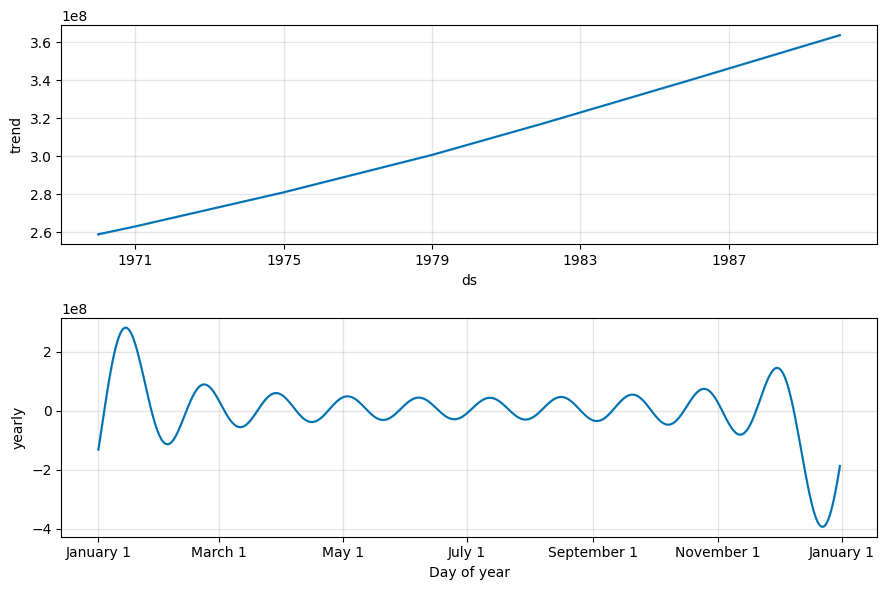

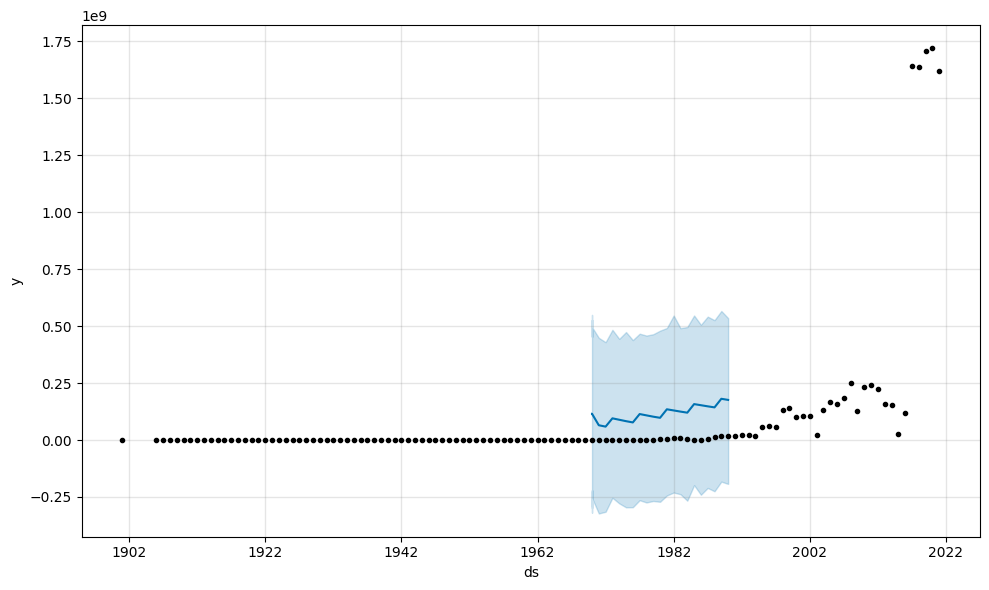

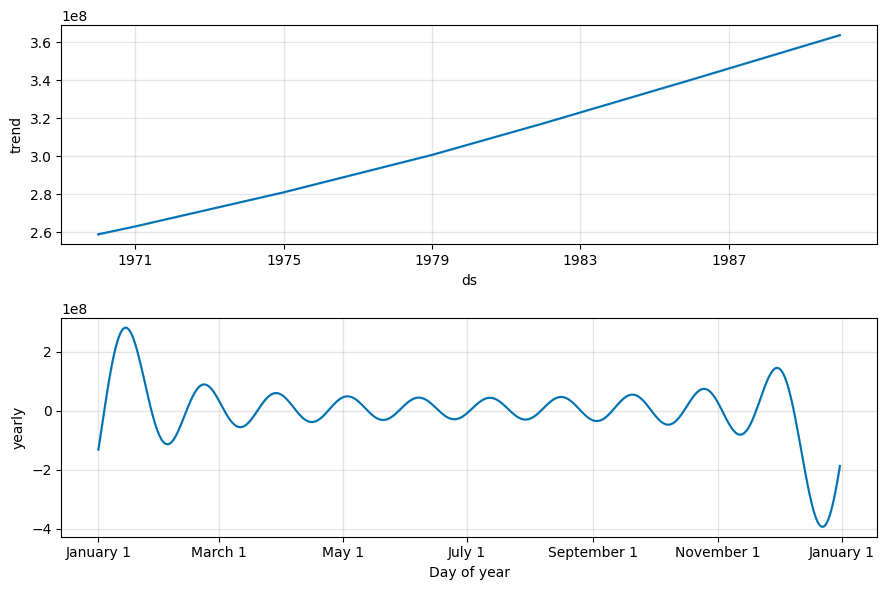

In [125]:
# Renombrar las columnas a 'ds' (fecha) y 'y' (valor)
data = df.loc[df.Region=='Caribbean', ['Year','ttl_adj_usd_damages']]
data = data.rename(columns={'Year': 'ds', 'ttl_adj_usd_damages': 'y'})
data = data.reset_index()
data['y'] = data.y.rolling(window=3).mean()
data = data.iloc[5:,]
# Crear una instancia del modelo Prophet
modelo = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Ajustar el modelo a los datos
modelo.fit(data)

# Generar fechas futuras para la predicción
futuro = modelo.make_future_dataframe(periods=20, freq='Y')  # Predicción para un año (365 días)

# Realizar la predicción
prediccion = modelo.predict(futuro)

# Visualizar la predicción
modelo.plot(prediccion)
modelo.plot_components(prediccion)

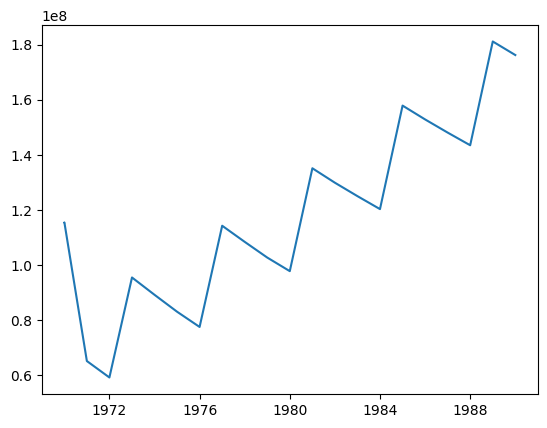

In [127]:
region = 'Caribbean'
var = 'No Injured'
#tmp = final.loc[(final.region==region)&(final.variable==var)]
plt.plot(prediccion['ds'],prediccion['yhat'])

In [76]:
#data = data.rename(columns={'Year': 'df', 'valor': 'ttl_adj_usd_damages'})
prediccion

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1900-01-01,3.198608e+09,-7.618764e+08,1.181691e+09,3.198608e+09,3.198608e+09,-3.026240e+09,-3.026240e+09,-3.026240e+09,-3.026240e+09,-3.026240e+09,-3.026240e+09,0.0,0.0,0.0,1.723680e+08
1,1902-01-01,3.208407e+09,-1.194882e+09,8.419441e+08,3.208407e+09,3.208407e+09,-3.403722e+09,-3.403722e+09,-3.403722e+09,-3.403722e+09,-3.403722e+09,-3.403722e+09,0.0,0.0,0.0,-1.953144e+08
2,1903-01-01,3.213307e+09,-1.235881e+09,7.196152e+08,3.213307e+09,3.213307e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,0.0,0.0,0.0,-2.761442e+08
3,1907-01-01,3.232918e+09,-1.317443e+09,6.385638e+08,3.232918e+09,3.232918e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,0.0,0.0,0.0,-2.565329e+08
4,1909-01-01,3.242730e+09,-1.005812e+09,1.029177e+09,3.242730e+09,3.242730e+09,-3.249243e+09,-3.249243e+09,-3.249243e+09,-3.249243e+09,-3.249243e+09,-3.249243e+09,0.0,0.0,0.0,-6.513209e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2036-12-31,3.870465e+09,-5.613997e+08,1.467604e+09,3.870462e+09,3.870469e+09,-3.454367e+09,-3.454367e+09,-3.454367e+09,-3.454367e+09,-3.454367e+09,-3.454367e+09,0.0,0.0,0.0,4.160985e+08
110,2037-12-31,3.875368e+09,-3.916258e+08,1.538574e+09,3.875364e+09,3.875372e+09,-3.333705e+09,-3.333705e+09,-3.333705e+09,-3.333705e+09,-3.333705e+09,-3.333705e+09,0.0,0.0,0.0,5.416623e+08
111,2038-12-31,3.880270e+09,-1.897818e+08,1.693783e+09,3.880266e+09,3.880275e+09,-3.144600e+09,-3.144600e+09,-3.144600e+09,-3.144600e+09,-3.144600e+09,-3.144600e+09,0.0,0.0,0.0,7.356706e+08
112,2039-12-31,3.885173e+09,-1.624768e+07,1.947300e+09,3.885168e+09,3.885178e+09,-2.887425e+09,-2.887425e+09,-2.887425e+09,-2.887425e+09,-2.887425e+09,-2.887425e+09,0.0,0.0,0.0,9.977478e+08


In [77]:
def predict_variable(df, vars, periods):
    results = {}
    idx = 0
    for var in vars:
        final = {}
        for region in df.Region.unique():
            data = df.loc[df.Region==region, ['Year',var]]
            data = data.rename(columns={'Year': 'ds', var: 'y'})
            modelo = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
            modelo.fit(data)
            futuro = modelo.make_future_dataframe(periods=periods, freq='Y')
            prediccion = modelo.predict(futuro)
            prediccion['variable'] = var
            prediccion['region'] = region
            results[idx] = prediccion
            idx = idx + 1
    return results

In [78]:
vars = ['No Injured','No Affected','No Homeless','Total Deaths','CPI', 'ins_adj_usd_damages','ttl_adj_usd_damages']
results = predict_variable(df, vars, 30)

14:51:48 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing
14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing
14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:51 - cmdstanpy - INFO - Chain [1] done processing
14:51:51 - cmdstanpy - INFO - Chain [1] start processing
14:51:51 - cmdstanpy - INFO - Chain [1] done processing
14:51:51 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1]

In [83]:
final.region.unique()

array(['Caribbean', 'Eastern Asia', 'Northern America', 'Southern Asia',
       'Western Africa', 'Western Asia', 'Eastern Africa',
       'Central America', 'South-Eastern Asia', 'Southern Europe',
       'South America', 'Western Europe', 'Eastern Europe',
       'Northern Africa', 'Middle Africa', 'Central Asia', 'Polynesia',
       'Australia and New Zealand', 'Melanesia', 'Northern Europe',
       'Southern Africa', 'Micronesia'], dtype=object)

In [159]:

final = pd.concat(results).reset_index()
final['pred_value'] = final['yhat']
final = final[['region','variable','ds','yhat_upper','yhat','pred_value']]

#Sanity Checks
final['pred_value'] = final.groupby(['region','variable']).yhat.rolling(window=5).mean().values
final['pred_value'] = np.where(final['pred_value']<0, 0, final['pred_value'])
final['ls_value'] = final.groupby(['region','variable']).yhat_upper.rolling(window=5).mean().values
final['ls_value'] = np.where(final['ls_value']<0, 0, final['ls_value'])

final.loc[final.pred_value.isna()==1,'pred_value'] = 0
final = final.loc[final.ds > pd.to_datetime("2021-01-01"),:]
final.head()

,region,variable,ds,yhat_upper,yhat,pred_value,ls_value
94,Caribbean,No Injured,2021-12-31,59400.717299,-18110.781116,0.000000,NaN
95,Caribbean,No Injured,2022-12-31,36883.420493,-40753.510169,88231.415516,1.502658e+06
96,Caribbean,No Injured,2023-12-31,4477.543803,-68328.181631,137718.816933,1.530930e+06
97,Caribbean,No Injured,2024-12-31,73303.151632,501.230820,151194.613531,1.538770e+06
98,Caribbean,No Injured,2025-12-31,55565.772468,-17169.962011,164670.410127,1.577900e+06


In [85]:
final.variable.unique()

array(['No Injured', 'No Affected', 'No Homeless', 'Total Deaths', 'CPI',
       'ins_adj_usd_damages', 'ttl_adj_usd_damages'], dtype=object)

In [141]:
final.loc[(final.variable=='ins_adj_usd_damages'),:]

,region,variable,ds,yhat_upper,yhat,pred_value
11614,Caribbean,ins_adj_usd_damages,2021-12-31,5.401502e+08,1.377210e+08,1.377210e+08
11615,Caribbean,ins_adj_usd_damages,2022-12-31,5.931919e+08,2.089722e+08,2.089722e+08
11616,Caribbean,ins_adj_usd_damages,2023-12-31,6.699959e+08,3.068923e+08,3.068923e+08
11617,Caribbean,ins_adj_usd_damages,2024-12-31,4.957868e+08,9.962756e+07,9.962756e+07
11618,Caribbean,ins_adj_usd_damages,2025-12-31,5.367576e+08,1.440678e+08,1.440678e+08
...,...,...,...,...,...,...
13819,Micronesia,ins_adj_usd_damages,2046-12-31,5.654114e+04,-5.822237e+05,2.827057e+04
13820,Micronesia,ins_adj_usd_damages,2047-12-31,1.285085e+04,-6.663257e+05,6.425426e+03
13821,Micronesia,ins_adj_usd_damages,2048-12-31,3.158350e+05,-3.818844e+05,1.579175e+05
13822,Micronesia,ins_adj_usd_damages,2049-12-31,2.221789e+05,-4.968574e+05,1.110895e+05


In [194]:
df_summary = df.melt(id_vars=['Year','Region'],
                    value_vars=['No Injured','No Affected','No Homeless','Total Deaths', 'ins_adj_usd_damages','ttl_adj_usd_damages'],
                    var_name='variable',
                    value_name='value'
                    )

In [195]:
final.to_csv('predictions_v0.csv', index=False)
df_summary.to_csv('real_v0.csv', index=False)

In [188]:
final

,region,variable,ds,yhat_upper,yhat,pred_value,ls_value
94,Caribbean,No Injured,2021-12-31,5.940072e+04,-1.811078e+04,0.000000e+00,NaN
95,Caribbean,No Injured,2022-12-31,3.688342e+04,-4.075351e+04,8.823142e+04,1.502658e+06
96,Caribbean,No Injured,2023-12-31,4.477544e+03,-6.832818e+04,1.377188e+05,1.530930e+06
97,Caribbean,No Injured,2024-12-31,7.330315e+04,5.012308e+02,1.511946e+05,1.538770e+06
98,Caribbean,No Injured,2025-12-31,5.556577e+04,-1.716996e+04,1.646704e+05,1.577900e+06
...,...,...,...,...,...,...,...
16123,Micronesia,ttl_adj_usd_damages,2046-12-31,2.972672e+06,-2.429638e+06,1.849630e+08,5.330491e+08
16124,Micronesia,ttl_adj_usd_damages,2047-12-31,2.397641e+06,-2.771624e+06,1.740843e+08,5.227742e+08
16125,Micronesia,ttl_adj_usd_damages,2048-12-31,3.652569e+06,-1.808185e+06,2.173175e+08,5.677173e+08
16126,Micronesia,ttl_adj_usd_damages,2049-12-31,3.039103e+06,-2.260481e+06,2.099379e+08,5.622305e+08


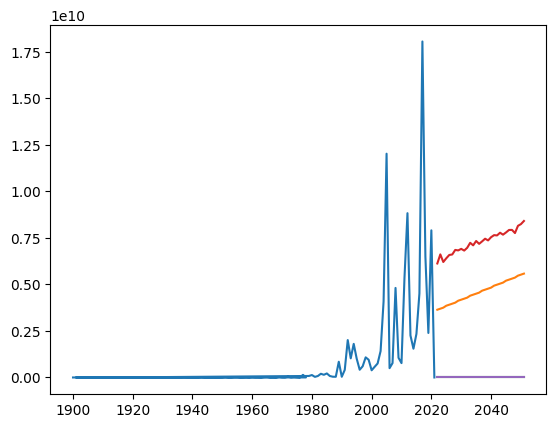

In [314]:
region = 'Northern America'#'Southern Asia'#
var = 'ttl_adj_usd_damages'
tmp1 = df.loc[(df.Region==region)]
plt.plot(tmp1['Year'],tmp1[var])
tmp = final.loc[(final.region==region)&(final.variable==var)]
plt.plot(tmp['ds'],tmp['yhat'])
plt.plot(tmp['ds'],tmp['pred_value'])
plt.plot(tmp['ds'],tmp['yhat_upper'])
plt.plot(tmp['ds'],tmp['ls_value'])

In [181]:
tmp1['Year']

1       1900
24      1902
47      1903
70      1904
93      1905
        ... 
2692    2017
2715    2018
2738    2019
2761    2020
2784    2021
Name: Year, Length: 122, dtype: int64

In [197]:
np.array(df.Region.unique())

array(['Western Africa', 'Southern Asia', 'Central America',
       'Northern America', 'Eastern Africa', 'South America',
       'Western Europe', 'Eastern Asia', 'Caribbean',
       'South-Eastern Asia', 'Northern Africa', 'Eastern Europe',
       'Southern Europe', 'Melanesia', 'Australia and New Zealand',
       'Polynesia', 'Northern Europe', 'Western Asia', 'Micronesia',
       'Southern Africa', 'Middle Africa', 'Russian Federation',
       'Central Asia'], dtype=object)

In [217]:
world_map

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [222]:
world_map

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [223]:
df1.columns

Index(['Year', 'Seq', 'Glide', 'Disaster Group', 'Disaster Subgroup',
       'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype',
       'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response',
       'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value',
       'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin',
       'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month',
       'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
       'Total Affected', 'ins_usd_damages', 'ttl_usd_damages', 'CPI',
       'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations',
       'ttl_adj_usd_damages', 'ins_adj_usd_damages'],
      dtype='object')

In [227]:
df2.ISO.unique()

array(['ARG', 'AUS', 'BEN', 'BGD', 'BRA', 'BRB', 'BWA', 'CAN', 'CHE',
       'CHN', 'CIV', 'COL', 'CRI', 'CUB', 'CYP', 'DMA', 'ECU', 'ETH',
       'FRA', 'GLP', 'HKG', 'HUN', 'IDN', 'IND', 'CHL', 'AFG', 'BEL',
       'CMR', 'ESP', 'GHA', 'GUY', 'HND', 'DFR', 'FJI', 'GBR', 'HTI',
       'CAF', 'DZA', 'GMB', 'GTM', 'BLZ', 'BOL', 'CSK', 'AUT', 'EGY',
       'GRD', 'BFA', 'DNK', 'GUM', 'BGR', 'COM', 'DJI', 'GRC', 'BDI',
       'BHR', 'PER', 'PNG', 'IRN', 'ISR', 'ITA', 'KOR', 'MAR', 'MDG',
       'MEX', 'MMR', 'MTQ', 'MYS', 'NER', 'NPL', 'PAN', 'PHL', 'PRI',
       'ROU', 'TUR', 'USA', 'JPN', 'KEN', 'LAO', 'MOZ', 'NIC', 'PRY',
       'SLB', 'TCD', 'TGO', 'KIR', 'MUS', 'NCL', 'NLD', 'PAK', 'TUV',
       'SOM', 'ISL', 'JAM', 'PRT', 'TON', 'TUN', 'LKA', 'LSO', 'RWA',
       'SUN', 'SYR', 'TTO', 'TZA', 'SDN', 'SLE', 'THA', 'MLI', 'MRT',
       'NZL', 'SEN', 'SWE', 'OMN', 'POL', 'REU', 'TWN', 'MDV', 'NGA',
       'VNM', 'VCT', 'VEN', 'VUT', 'YMD', 'YUG', 'YMN', 'ZAF', 'ZWE',
       'COD', 'ZMB',

In [226]:
world_map.iso_a3.unique()

array(['FJI', 'TZA', 'ESH', 'CAN', 'USA', 'KAZ', 'UZB', 'PNG', 'IDN',
       'ARG', 'CHL', 'COD', 'SOM', 'KEN', 'SDN', 'TCD', 'HTI', 'DOM',
       'RUS', 'BHS', 'FLK', 'NOR', 'GRL', 'ATF', 'TLS', 'ZAF', 'LSO',
       'MEX', 'URY', 'BRA', 'BOL', 'PER', 'COL', 'PAN', 'CRI', 'NIC',
       'HND', 'SLV', 'GTM', 'BLZ', 'VEN', 'GUY', 'SUR', 'FRA', 'ECU',
       'PRI', 'JAM', 'CUB', 'ZWE', 'BWA', 'NAM', 'SEN', 'MLI', 'MRT',
       'BEN', 'NER', 'NGA', 'CMR', 'TGO', 'GHA', 'CIV', 'GIN', 'GNB',
       'LBR', 'SLE', 'BFA', 'CAF', 'COG', 'GAB', 'GNQ', 'ZMB', 'MWI',
       'MOZ', 'SWZ', 'AGO', 'BDI', 'ISR', 'LBN', 'MDG', 'PSE', 'GMB',
       'TUN', 'DZA', 'JOR', 'ARE', 'QAT', 'KWT', 'IRQ', 'OMN', 'VUT',
       'KHM', 'THA', 'LAO', 'MMR', 'VNM', 'PRK', 'KOR', 'MNG', 'IND',
       'BGD', 'BTN', 'NPL', 'PAK', 'AFG', 'TJK', 'KGZ', 'TKM', 'IRN',
       'SYR', 'ARM', 'SWE', 'BLR', 'UKR', 'POL', 'AUT', 'HUN', 'MDA',
       'ROU', 'LTU', 'LVA', 'EST', 'DEU', 'BGR', 'GRC', 'TUR', 'ALB',
       'HRV', 'CHE',

In [202]:
world_map.unique()

array(['Oceania', 'Africa', 'North America', 'Asia', 'South America',
       'Europe', 'Seven seas (open ocean)', 'Antarctica'], dtype=object)

In [221]:
df1.Continent.unique()

array(['Africa', 'Asia', 'Americas', 'Europe', 'Oceania'], dtype=object)

In [273]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el archivo shapefile del mapa mundial
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#filtered_map = world_map[world_map['subregion'].isin(regiones)]



C:\Users\BeltrameE\AppData\Local\Temp\ipykernel_3340\1208217106.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [277]:
iso_dict = pd.pivot_table(data=df1,
               index=['ISO','Region'],
               values=['No Injured'],
               aggfunc=len).reset_index()
del iso_dict['No Injured']
iso_dict

wmap = pd.merge(world_map, iso_dict, how='left', left_on='iso_a3', right_on='ISO')
wmap = pd.merge(final, wmap, how='left', left_on='region', right_on='Region')
wmap = gpd.GeoDataFrame(wmap,
                        geometry='geometry')
type(wmap)

geopandas.geodataframe.GeoDataFrame

In [306]:
wmap0 = pd.merge(world_map, iso_dict, how='left', left_on='iso_a3', right_on='ISO')
wmap0 = pd.merge(df_summary, wmap0, how='left', left_on='Region', right_on='Region')
wmap0 = gpd.GeoDataFrame(wmap0,
                        geometry='geometry')
wmap0['pred_value'] = wmap0['value']
wmap0['ds'] = wmap0['Year']
type(wmap0)

geopandas.geodataframe.GeoDataFrame

In [305]:
wmap0

,Year,Region,variable,value,pop_est,continent,name,iso_a3,gdp_md_est,geometry,ISO,pred_value
0,1900-01-01,Western Africa,No Injured,0.0,16296364.0,Africa,Senegal,SEN,23578.0,"POLYGON ((-16.71373 13.59496, -17.12611 14.373...",SEN,0.0
1,1900-01-01,Western Africa,No Injured,0.0,19658031.0,Africa,Mali,MLI,17279.0,"POLYGON ((-11.51394 12.44299, -11.46790 12.754...",MLI,0.0
2,1900-01-01,Western Africa,No Injured,0.0,4525696.0,Africa,Mauritania,MRT,7600.0,"POLYGON ((-17.06342 20.99975, -16.84519 21.333...",MRT,0.0
3,1900-01-01,Western Africa,No Injured,0.0,11801151.0,Africa,Benin,BEN,14390.0,"POLYGON ((2.69170 6.25882, 1.86524 6.14216, 1....",BEN,0.0
4,1900-01-01,Western Africa,No Injured,0.0,23310715.0,Africa,Niger,NER,12911.0,"POLYGON ((14.85130 22.86295, 15.09689 21.30852...",NER,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
125899,2021-01-01,Central Asia,ttl_adj_usd_damages,0.0,18513930.0,Asia,Kazakhstan,KAZ,181665.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",KAZ,0.0
125900,2021-01-01,Central Asia,ttl_adj_usd_damages,0.0,33580650.0,Asia,Uzbekistan,UZB,57921.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",UZB,0.0
125901,2021-01-01,Central Asia,ttl_adj_usd_damages,0.0,9321018.0,Asia,Tajikistan,TJK,8116.0,"POLYGON ((67.83000 37.14499, 68.39203 38.15703...",TJK,0.0
125902,2021-01-01,Central Asia,ttl_adj_usd_damages,0.0,6456900.0,Asia,Kyrgyzstan,KGZ,8454.0,"POLYGON ((70.96231 42.26615, 71.18628 42.70429...",KGZ,0.0


In [329]:
def plot_map(wmap, var, year):
    # Crear una figura y un eje
    fig, ax = plt.subplots(figsize=(10, 6))

    # Graficar el mapa mundial filtrado
    #world_map.plot(ax=ax, color='lightgray', edgecolor='black')
    #year = pd.to_datetime('2030-12-31')
    #year = pd.to_datetime(f'{year}-12-31')
    #var = 'ttl_adj_usd_damages'
    #var = 'ins_adj_usd_damages'

    tmp = wmap.loc[(wmap.ds==year)&(wmap.variable==var),['geometry','pred_value']]

    tmp.plot(ax=ax,
           column='pred_value',
           cmap='Reds',
           edgecolor='lightgray'
                )

    # Agregar título y ajustar la apariencia
    ax.set_title(f'{var}_in_{year.year}')
    ax.set_xlim([-180, 180])
    ax.set_ylim([-90, 90])
    ax.axis('off')

    # Mostrar el gráfico
    plt.show()

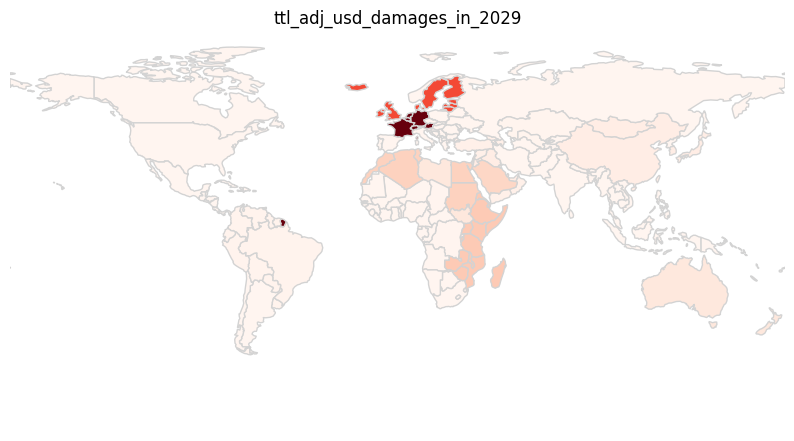

In [330]:
var = 'ttl_adj_usd_damages'
year = pd.to_datetime(f'2029-12-31')
plot_map(wmap, var, year)

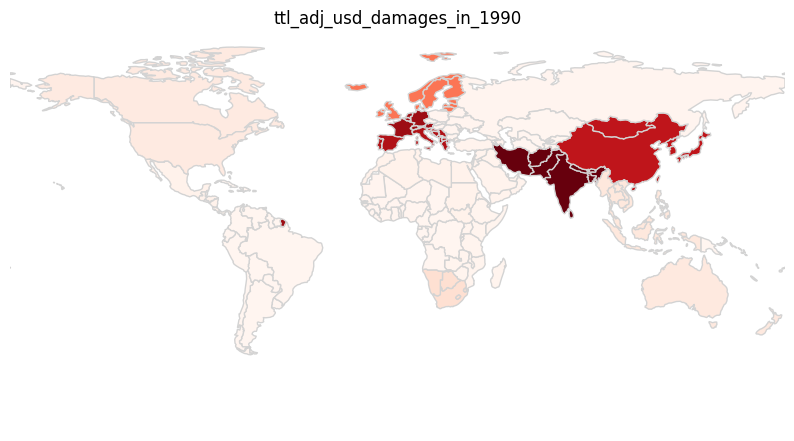

In [331]:
year = pd.to_datetime(f'1990-01-01')
plot_map(wmap0, var, year)

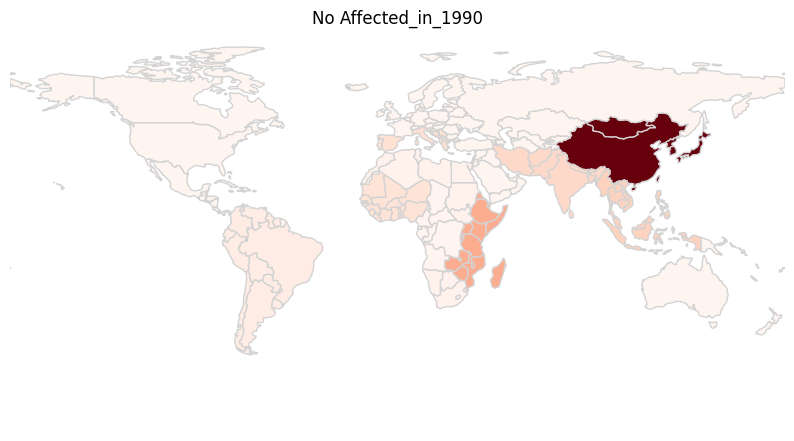

In [332]:
var = 'No Affected'
year = pd.to_datetime(f'1990-01-01')
plot_map(wmap0, var, year)

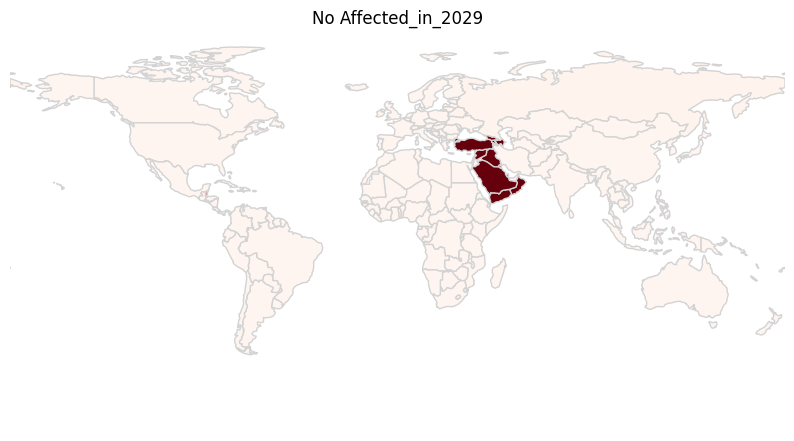

In [333]:
var = 'No Affected'
year = pd.to_datetime(f'2029-12-31')
plot_map(wmap, var, year)

In [257]:
year = pd.to_datetime('2030-12-31')
wmap.loc[(wmap.ds==year)&(wmap.variable==var)]

,region,variable,ds,yhat_upper,yhat,pred_value,ls_value,pop_est,continent,name,iso_a3,gdp_md_est,geometry,ISO,Region
5193,Caribbean,No Affected,2030-12-31,4.572608e+06,2.595051e+06,1.502739e+06,2.543117e+06,11263077.0,North America,Haiti,HTI,14332.0,"POLYGON ((-71.71236 19.71446, -71.62487 19.169...",HTI,Caribbean
5194,Caribbean,No Affected,2030-12-31,4.572608e+06,2.595051e+06,1.502739e+06,2.543117e+06,10738958.0,North America,Dominican Rep.,DOM,88941.0,"POLYGON ((-71.70830 18.04500, -71.68774 18.316...",DOM,Caribbean
5195,Caribbean,No Affected,2030-12-31,4.572608e+06,2.595051e+06,1.502739e+06,2.543117e+06,389482.0,North America,Bahamas,BHS,13578.0,"MULTIPOLYGON (((-78.98000 26.79000, -78.51000 ...",BHS,Caribbean
5196,Caribbean,No Affected,2030-12-31,4.572608e+06,2.595051e+06,1.502739e+06,2.543117e+06,3193694.0,North America,Puerto Rico,PRI,104988.0,"POLYGON ((-66.28243 18.51476, -65.77130 18.426...",PRI,Caribbean
5197,Caribbean,No Affected,2030-12-31,4.572608e+06,2.595051e+06,1.502739e+06,2.543117e+06,2948279.0,North America,Jamaica,JAM,16458.0,"POLYGON ((-77.56960 18.49053, -76.89662 18.400...",JAM,Caribbean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10126,Southern Africa,No Affected,2030-12-31,6.791496e+06,4.115513e+06,3.024662e+05,9.866943e+05,2125268.0,Africa,Lesotho,LSO,2376.0,"POLYGON ((28.97826 -28.95560, 29.32517 -29.257...",LSO,Southern Africa
10127,Southern Africa,No Affected,2030-12-31,6.791496e+06,4.115513e+06,3.024662e+05,9.866943e+05,2303697.0,Africa,Botswana,BWA,18340.0,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",BWA,Southern Africa
10128,Southern Africa,No Affected,2030-12-31,6.791496e+06,4.115513e+06,3.024662e+05,9.866943e+05,2494530.0,Africa,Namibia,NAM,12366.0,"POLYGON ((19.89577 -24.76779, 19.89473 -28.461...",NAM,Southern Africa
10129,Southern Africa,No Affected,2030-12-31,6.791496e+06,4.115513e+06,3.024662e+05,9.866943e+05,1148130.0,Africa,eSwatini,SWZ,4471.0,"POLYGON ((32.07167 -26.73382, 31.86806 -27.177...",SWZ,Southern Africa


In [229]:
df1.Country.unique()
Pais = [x for x in df1.ISO.unique() if x in world_map.iso_a3.unique()]
not_found = [x for x in df1.ISO.unique() if x not in world_map.iso_a3.unique()]
print(len(Pais), len(not_found))

169 59


In [231]:
dfn = df1.loc[df1.ISO.isin(world_map.iso_a3.unique())]
print(len(df1),len(dfn))

16126 15373


In [238]:
dfn

,Year,Region,No Affected,No Homeless,No Injured,Total Deaths,ins_adj_usd_damages,ttl_adj_usd_damages
0,1900-01-01,Western Africa,0.0,0.0,0.0,0.0,0.0,0.00000
1,1900-01-01,Southern Asia,0.0,0.0,0.0,1250000.0,0.0,0.00000
2,1900-01-01,Central America,0.0,0.0,0.0,0.0,0.0,0.00000
3,1900-01-01,Northern America,0.0,0.0,0.0,6000.0,0.0,96649.41813
4,1900-01-01,Eastern Africa,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...
2801,2021-01-01,Micronesia,0.0,0.0,0.0,0.0,0.0,0.00000
2802,2021-01-01,Southern Africa,6551.0,0.0,0.0,35.0,0.0,0.00000
2803,2021-01-01,Middle Africa,551977.0,22000.0,635.0,227.0,0.0,0.00000
2804,2021-01-01,Russian Federation,0.0,0.0,0.0,0.0,0.0,0.00000


In [287]:
final.head()

,region,variable,ds,yhat_upper,yhat,pred_value,ls_value
94,Caribbean,No Injured,2021-12-31,59400.717299,-18110.781116,0.000000,NaN
95,Caribbean,No Injured,2022-12-31,36883.420493,-40753.510169,88231.415516,1.502658e+06
96,Caribbean,No Injured,2023-12-31,4477.543803,-68328.181631,137718.816933,1.530930e+06
97,Caribbean,No Injured,2024-12-31,73303.151632,501.230820,151194.613531,1.538770e+06
98,Caribbean,No Injured,2025-12-31,55565.772468,-17169.962011,164670.410127,1.577900e+06


In [290]:
df_summary.head()

,Year,Region,variable,value
0,1900-01-01,Western Africa,No Injured,0.0
1,1900-01-01,Southern Asia,No Injured,0.0
2,1900-01-01,Central America,No Injured,0.0
3,1900-01-01,Northern America,No Injured,0.0
4,1900-01-01,Eastern Africa,No Injured,0.0


In [235]:
dfn = preprocess_df(dfn, df_all)
dfn

,Year,Region,No Affected,No Homeless,No Injured,Total Deaths,ins_adj_usd_damages,ttl_adj_usd_damages
0,1900-01-01,Western Africa,0.0,0.0,0.0,0.0,0.0,0.00000
1,1900-01-01,Southern Asia,0.0,0.0,0.0,1250000.0,0.0,0.00000
2,1900-01-01,Central America,0.0,0.0,0.0,0.0,0.0,0.00000
3,1900-01-01,Northern America,0.0,0.0,0.0,6000.0,0.0,96649.41813
4,1900-01-01,Eastern Africa,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...
2801,2021-01-01,Micronesia,0.0,0.0,0.0,0.0,0.0,0.00000
2802,2021-01-01,Southern Africa,6551.0,0.0,0.0,35.0,0.0,0.00000
2803,2021-01-01,Middle Africa,551977.0,22000.0,635.0,227.0,0.0,0.00000
2804,2021-01-01,Russian Federation,0.0,0.0,0.0,0.0,0.0,0.00000


In [236]:
vars = ['No Injured','No Affected','No Homeless','Total Deaths','ins_adj_usd_damages','ttl_adj_usd_damages']
results_new = predict_variable(dfn, vars, 30)

18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
18:07:03 - cmdstanpy - INFO - Chain [1] start processing
18:07:03 - cmdstanpy - INFO - Chain [1] done processing
18:07:03 - cmdstanpy - INFO - Chain [1] start processing
18:07:03 - cmdstanpy - INFO - Chain [1] done processing
18:07:03 - cmdstanpy - INFO - Chain [1] start processing
18:07:03 - cmdstanpy - INFO - Chain [1]

KeyError: "['Total Deathsins_adj_usd_damages'] not in index"

In [340]:
joined = final.copy()
joined['Region'] = joined.region
joined['value'] = joined.pred_value
joined['Year'] = joined.ds
joined = pd.concat([df_summary, joined[df_summary.columns]], axis=0)

In [342]:
joined.to_csv('pjoined_v0.csv', index=False)

In [335]:
df_summary.head()

,Year,Region,variable,value
0,1900-01-01,Western Africa,No Injured,0.0
1,1900-01-01,Southern Asia,No Injured,0.0
2,1900-01-01,Central America,No Injured,0.0
3,1900-01-01,Northern America,No Injured,0.0
4,1900-01-01,Eastern Africa,No Injured,0.0
